In [2]:
import pandas as pd
import numpy as np
import warnings
import os
import pickle
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, accuracy_score, precision_score, 
                            recall_score, roc_auc_score, confusion_matrix)

# Advanced models
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False
    print("[WARNING] XGBoost not installed")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("[WARNING] LightGBM not installed")

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except:
    CATBOOST_AVAILABLE = False
    print("[WARNING] CatBoost not installed")

# SMOTE
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except:
    SMOTE_AVAILABLE = False
    print("[WARNING] imbalanced-learn not installed, SMOTE disabled")

# Optuna
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    OPTUNA_AVAILABLE = True
except:
    OPTUNA_AVAILABLE = False
    print("[WARNING] Optuna not installed, using default hyperparameters")

print("\n" + "="*80)
print("FRAUD DETECTION ML PIPELINE - TRAINING")
print("="*80)



FRAUD DETECTION ML PIPELINE - TRAINING


In [3]:
# ============================================================
# STEP 1: LOAD DATA
# ============================================================

print("\n[STEP 1] LOADING DATA")
print("-"*80)

df = pd.read_csv(r"C:\Users\KIIT\OneDrive\Desktop\MAJOR FINAL PROJECT FOLDER\enhanced_fraud_dataset_with_scores.csv")

print(f"[OK] Dataset: {df.shape}")
print(f"[OK] Fraud: {df['IsFraud'].sum()} ({df['IsFraud'].sum()/len(df)*100:.1f}%)")
print(f"[OK] Legitimate: {(1-df['IsFraud']).sum()} ({(1-df['IsFraud']).sum()/len(df)*100:.1f}%)")


[STEP 1] LOADING DATA
--------------------------------------------------------------------------------
[OK] Dataset: (1000, 19)
[OK] Fraud: 534 (53.4%)
[OK] Legitimate: 466 (46.6%)


In [4]:
# ============================================================
# STEP 2: PREPARE FEATURES
# ============================================================

print("\n[STEP 2] PREPARING FEATURES")
print("-"*80)

# Exclude columns (Transaction Date kept for Flask to handle separately)
exclude_cols = ['Transaction ID', 'IsFraud', 'Fraud_Score', 'Fraud_Level', 'Transaction Date']
X = df.drop(exclude_cols, axis=1, errors='ignore')
y = df['IsFraud'].values

# Save feature column order for Flask
feature_columns = list(X.columns)

print(f"[OK] Features (X): {X.shape}")
print(f"[OK] Target (y): {y.shape}")
print(f"[OK] Feature columns: {feature_columns}")


[STEP 2] PREPARING FEATURES
--------------------------------------------------------------------------------
[OK] Features (X): (1000, 14)
[OK] Target (y): (1000,)
[OK] Feature columns: ['Customer_Id', 'Customer Name', 'Customer State', 'Transaction Category', 'Card Type', 'BANK ID', 'Bank', 'Merchant Id', 'Merchant Name', 'Merchant Location', 'Transaction Amount', 'Transaction Hour', 'Card Present', 'International']


In [5]:
# ============================================================
# STEP 3: ENCODE & SCALE
# ============================================================

print("\n[STEP 3] PREPROCESSING")
print("-"*80)

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"[OK] Categorical: {len(categorical_cols)} columns")
print(f"     {categorical_cols}")
print(f"[OK] Numeric: {len(numeric_cols)} columns")
print(f"     {numeric_cols}")

# Label encode categorical
X_processed = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le

print(f"[OK] Encoded {len(categorical_cols)} categorical columns")

# Scale numeric
scaler = StandardScaler()
X_processed[numeric_cols] = scaler.fit_transform(X_processed[numeric_cols])

print(f"[OK] Scaled {len(numeric_cols)} numeric columns")
print(f"[OK] Final shape: {X_processed.shape}")


[STEP 3] PREPROCESSING
--------------------------------------------------------------------------------
[OK] Categorical: 10 columns
     ['Customer_Id', 'Customer Name', 'Customer State', 'Transaction Category', 'Card Type', 'BANK ID', 'Bank', 'Merchant Id', 'Merchant Name', 'Merchant Location']
[OK] Numeric: 4 columns
     ['Transaction Amount', 'Transaction Hour', 'Card Present', 'International']
[OK] Encoded 10 categorical columns
[OK] Scaled 4 numeric columns
[OK] Final shape: (1000, 14)


In [6]:
# ============================================================
# STEP 4: TRAIN/TEST SPLIT
# ============================================================

print("\n[STEP 4] SPLITTING DATA")
print("-"*80)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

print(f"[OK] Train: {X_train.shape[0]} samples ({y_train.sum()} fraud)")
print(f"[OK] Test: {X_test.shape[0]} samples ({y_test.sum()} fraud)")


[STEP 4] SPLITTING DATA
--------------------------------------------------------------------------------
[OK] Train: 800 samples (427 fraud)
[OK] Test: 200 samples (107 fraud)


In [7]:
# ============================================================
# STEP 5: APPLY SMOTE
# ============================================================

if SMOTE_AVAILABLE:
    print("\n[STEP 5] APPLYING SMOTE")
    print("-"*80)
    
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"[OK] Before SMOTE: {X_train.shape[0]} samples")
    print(f"[OK] After SMOTE: {X_train_balanced.shape[0]} samples")
    print(f"[OK] Fraud: {y_train_balanced.sum()} ({y_train_balanced.sum()/len(y_train_balanced)*100:.1f}%)")
else:
    print("\n[STEP 5] SKIPPING SMOTE (not available)")
    X_train_balanced = X_train
    y_train_balanced = y_train


[STEP 5] APPLYING SMOTE
--------------------------------------------------------------------------------
[OK] Before SMOTE: 800 samples
[OK] After SMOTE: 854 samples
[OK] Fraud: 427 (50.0%)


In [8]:
# ============================================================
# STEP 6: TRAIN MODELS
# ============================================================

print("\n[STEP 6] TRAINING MODELS")
print("="*80)

models = {}
results = []

# -------------------------
# MODEL 1: LOGISTIC REGRESSION
# -------------------------
print("\n[1/5] LOGISTIC REGRESSION")
print("-"*80)

if OPTUNA_AVAILABLE:
    def objective_lr(trial):
        C = trial.suggest_float('C', 0.001, 10.0, log=True)
        model = LogisticRegression(C=C, max_iter=2000, class_weight='balanced', random_state=42)
        model.fit(X_train_balanced, y_train_balanced)
        y_val_pred = model.predict(X_test)
        return f1_score(y_test, y_val_pred)
    
    study_lr = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study_lr.optimize(objective_lr, n_trials=20, show_progress_bar=False)
    best_C = study_lr.best_params['C']
    print(f"[Optuna] Best C: {best_C:.4f}")
else:
    best_C = 1.0
    print(f"[Default] C: {best_C}")

lr_model = LogisticRegression(C=best_C, max_iter=2000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1-Score': f1_score(y_test, y_pred_lr),
    'AUC-ROC': roc_auc_score(y_test, y_proba_lr)
})
print(f"[OK] F1-Score: {results[-1]['F1-Score']:.4f}")

# -------------------------
# MODEL 2: RANDOM FOREST
# -------------------------
print("\n[2/5] RANDOM FOREST")
print("-"*80)

if OPTUNA_AVAILABLE:
    def objective_rf(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train_balanced, y_train_balanced)
        y_val_pred = model.predict(X_test)
        return f1_score(y_test, y_val_pred)
    
    study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=False)
    best_n_est = study_rf.best_params['n_estimators']
    best_depth = study_rf.best_params['max_depth']
    print(f"[Optuna] Best n_estimators: {best_n_est}, max_depth: {best_depth}")
else:
    best_n_est, best_depth = 100, 10
    print(f"[Default] n_estimators: {best_n_est}, max_depth: {best_depth}")

rf_model = RandomForestClassifier(
    n_estimators=best_n_est,
    max_depth=best_depth,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_proba_rf)
})
print(f"[OK] F1-Score: {results[-1]['F1-Score']:.4f}")

# -------------------------
# MODEL 3: XGBOOST
# -------------------------
if XGBOOST_AVAILABLE:
    print("\n[3/5] XGBOOST")
    print("-"*80)
    
    if OPTUNA_AVAILABLE:
        def objective_xgb(trial):
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'random_state': 42,
                'eval_metric': 'logloss'
            }
            model = XGBClassifier(**params)
            model.fit(X_train_balanced, y_train_balanced)
            y_val_pred = model.predict(X_test)
            return f1_score(y_test, y_val_pred)
        
        study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
        study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=False)
        best_params_xgb = study_xgb.best_params
        print(f"[Optuna] Best params: {best_params_xgb}")
    else:
        best_params_xgb = {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 100}
        print(f"[Default] params: {best_params_xgb}")
    
    xgb_model = XGBClassifier(**best_params_xgb, random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train_balanced, y_train_balanced)
    models['XGBoost'] = xgb_model
    
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1-Score': f1_score(y_test, y_pred_xgb),
        'AUC-ROC': roc_auc_score(y_test, y_proba_xgb)
    })
    print(f"[OK] F1-Score: {results[-1]['F1-Score']:.4f}")

# -------------------------
# MODEL 4: LIGHTGBM
# -------------------------
if LIGHTGBM_AVAILABLE:
    print("\n[4/5] LIGHTGBM")
    print("-"*80)
    
    if OPTUNA_AVAILABLE:
        def objective_lgb(trial):
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100),
                'random_state': 42,
                'verbose': -1
            }
            model = LGBMClassifier(**params)
            model.fit(X_train_balanced, y_train_balanced)
            y_val_pred = model.predict(X_test)
            return f1_score(y_test, y_val_pred)
        
        study_lgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
        study_lgb.optimize(objective_lgb, n_trials=20, show_progress_bar=False)
        best_params_lgb = study_lgb.best_params
        print(f"[Optuna] Best params: {best_params_lgb}")
    else:
        best_params_lgb = {'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
        print(f"[Default] params: {best_params_lgb}")
    
    lgb_model = LGBMClassifier(**best_params_lgb, random_state=42, verbose=-1)
    lgb_model.fit(X_train_balanced, y_train_balanced)
    models['LightGBM'] = lgb_model
    
    y_pred_lgb = lgb_model.predict(X_test)
    y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
    results.append({
        'Model': 'LightGBM',
        'Accuracy': accuracy_score(y_test, y_pred_lgb),
        'Precision': precision_score(y_test, y_pred_lgb),
        'Recall': recall_score(y_test, y_pred_lgb),
        'F1-Score': f1_score(y_test, y_pred_lgb),
        'AUC-ROC': roc_auc_score(y_test, y_proba_lgb)
    })
    print(f"[OK] F1-Score: {results[-1]['F1-Score']:.4f}")

# -------------------------
# MODEL 5: CATBOOST
# -------------------------
if CATBOOST_AVAILABLE:
    print("\n[5/5] CATBOOST")
    print("-"*80)
    
    if OPTUNA_AVAILABLE:
        def objective_cat(trial):
            params = {
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'iterations': trial.suggest_int('iterations', 50, 200),
                'random_state': 42,
                'verbose': 0
            }
            model = CatBoostClassifier(**params)
            model.fit(X_train_balanced, y_train_balanced)
            y_val_pred = model.predict(X_test)
            return f1_score(y_test, y_val_pred)
        
        study_cat = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
        study_cat.optimize(objective_cat, n_trials=20, show_progress_bar=False)
        best_params_cat = study_cat.best_params
        print(f"[Optuna] Best params: {best_params_cat}")
    else:
        best_params_cat = {'depth': 6, 'learning_rate': 0.1, 'iterations': 100}
        print(f"[Default] params: {best_params_cat}")
    
    cat_model = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0)
    cat_model.fit(X_train_balanced, y_train_balanced)
    models['CatBoost'] = cat_model
    
    y_pred_cat = cat_model.predict(X_test)
    y_proba_cat = cat_model.predict_proba(X_test)[:, 1]
    results.append({
        'Model': 'CatBoost',
        'Accuracy': accuracy_score(y_test, y_pred_cat),
        'Precision': precision_score(y_test, y_pred_cat),
        'Recall': recall_score(y_test, y_pred_cat),
        'F1-Score': f1_score(y_test, y_pred_cat),
        'AUC-ROC': roc_auc_score(y_test, y_proba_cat)
    })
    print(f"[OK] F1-Score: {results[-1]['F1-Score']:.4f}")


[STEP 6] TRAINING MODELS

[1/5] LOGISTIC REGRESSION
--------------------------------------------------------------------------------
[Optuna] Best C: 6.3512
[OK] F1-Score: 0.7706

[2/5] RANDOM FOREST
--------------------------------------------------------------------------------
[Optuna] Best n_estimators: 53, max_depth: 20
[OK] F1-Score: 0.7378

[3/5] XGBOOST
--------------------------------------------------------------------------------
[Optuna] Best params: {'max_depth': 3, 'learning_rate': 0.13978797382253277, 'n_estimators': 115}
[OK] F1-Score: 0.7945

[4/5] LIGHTGBM
--------------------------------------------------------------------------------
[Optuna] Best params: {'max_depth': 3, 'learning_rate': 0.1359633188093593, 'n_estimators': 151, 'num_leaves': 74}
[OK] F1-Score: 0.7834

[5/5] CATBOOST
--------------------------------------------------------------------------------
[Optuna] Best params: {'depth': 5, 'learning_rate': 0.19828108267723504, 'iterations': 167}
[OK] F1-Sco

In [9]:
# ============================================================
# STEP 7: COMPARE MODELS
# ============================================================

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print(results_df.to_string(index=False))

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
best_f1 = results_df.iloc[0]['F1-Score']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name} (F1-Score: {best_f1:.4f})")
print(f"{'='*80}")


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
            XGBoost     0.775   0.776786 0.813084  0.794521 0.837202
           CatBoost     0.775   0.776786 0.813084  0.794521 0.827656
           LightGBM     0.765   0.772727 0.794393  0.783410 0.830268
Logistic Regression     0.750   0.756757 0.785047  0.770642 0.805849
      Random Forest     0.705   0.703390 0.775701  0.737778 0.778113

BEST MODEL: XGBoost (F1-Score: 0.7945)


In [10]:
# ============================================================
# STEP 8: SAVE BEST MODEL
# ============================================================

print("\n[STEP 8] SAVING FILES")
print("-"*80)

output_dir = "production_deployment"
os.makedirs(output_dir, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save model
model_path = f"{output_dir}/fraud_model_{timestamp}.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"[OK] Model: {model_path}")

# Save preprocessors + feature columns for Flask
preprocess_path = f"{output_dir}/preprocessor_{timestamp}.pkl"
preprocessors = {
    'label_encoders': label_encoders,
    'scaler': scaler,
    'categorical_cols': categorical_cols,
    'numeric_cols': numeric_cols,
    'feature_columns': feature_columns  # ADDED FOR FLASK
}
with open(preprocess_path, 'wb') as f:
    pickle.dump(preprocessors, f)
print(f"[OK] Preprocessor: {preprocess_path}")

# Save config
config_path = f"{output_dir}/model_config_{timestamp}.json"
config = {
    'model_name': best_model_name,
    'timestamp': timestamp,
    'test_accuracy': float(results_df.iloc[0]['Accuracy']),
    'test_f1_score': float(results_df.iloc[0]['F1-Score']),
    'test_precision': float(results_df.iloc[0]['Precision']),
    'test_recall': float(results_df.iloc[0]['Recall']),
    'test_auc_roc': float(results_df.iloc[0]['AUC-ROC']),
    'fraud_level_rules': {
        'LOW': '0-30',
        'MEDIUM': '31-60',
        'HIGH': '61-80',
        'CRITICAL': '81-100'
    },
    'all_models_comparison': results_df.to_dict('records')
}
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"[OK] Config: {config_path}")

# Save comparison CSV
comparison_path = f"{output_dir}/model_comparison_{timestamp}.csv"
results_df.to_csv(comparison_path, index=False)
print(f"[OK] Comparison: {comparison_path}")


[STEP 8] SAVING FILES
--------------------------------------------------------------------------------
[OK] Model: production_deployment/fraud_model_20251121_234544.pkl
[OK] Preprocessor: production_deployment/preprocessor_20251121_234544.pkl
[OK] Config: production_deployment/model_config_20251121_234544.json
[OK] Comparison: production_deployment/model_comparison_20251121_234544.csv


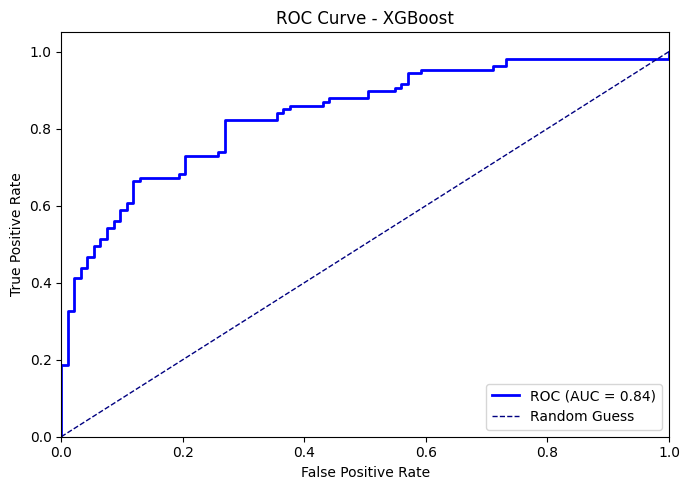

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# For XGBoost, after predictions:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


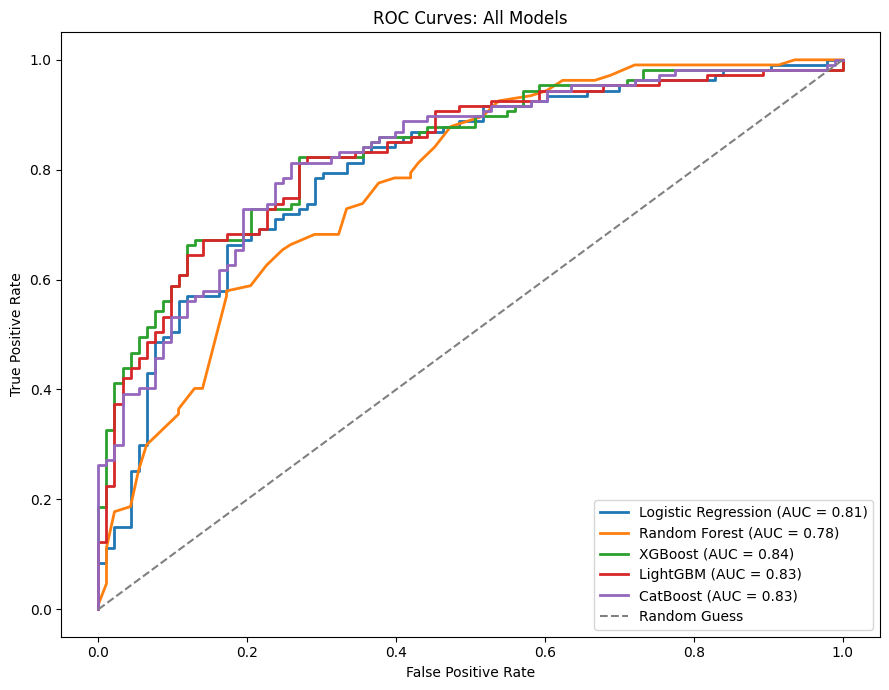

In [12]:
plt.figure(figsize=(9,7))
for name, proba in [('Logistic Regression', y_proba_lr), 
                    ('Random Forest', y_proba_rf), 
                    ('XGBoost', y_proba_xgb),
                    ('LightGBM', y_proba_lgb), 
                    ('CatBoost', y_proba_cat)]:
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'--',color='gray',label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: All Models')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
